A contaminant model for a 5 arc second neighbourhood search

In [3]:
import numpy as np

In [4]:
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd
import healpy as hp
%matplotlib inline
mp.rcParams['figure.figsize'] = (12, 8)

In [5]:
from astroquery.gaia import gaia

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [6]:
%run ../../NoteBooks/alex/tools/hp4gaia.py

# DR1 data
VLBI sources

tables = gaia.load_tables()

In [ ]:
t = tables[0]

In [ ]:
t.get_name()

In [ ]:
for t in tables :
    print(t.get_name())

# Random source selection in DR1

this selection can be used to generate fake QSO lenses due to star contamination  

In [9]:
query = "SELECT TOP 1000000 gaia.source_id, gaia.phot_g_mean_mag FROM gaiadr1.gaia_source AS gaia WHERE gaia.random_index<1000000"

In [10]:
r = gaia.launch_job(query).get_data() 

Launched query: 'SELECT TOP 1000000 gaia.source_id, gaia.phot_g_mean_mag FROM gaiadr1.gaia_source AS gaia WHERE gaia.random_index<1000000'
Retrieving sync. results...


Query finished.


In [11]:
d = r.to_pandas()

In [12]:
d.columns

Index(['source_id', 'phot_g_mean_mag'], dtype='object')

In [13]:
level = 6

In [14]:
hpX = hpExpr(level)

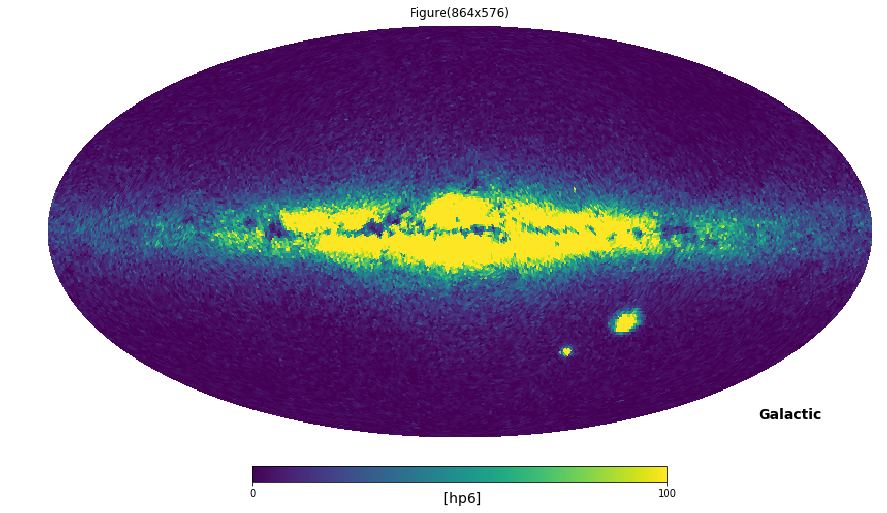

In [15]:
hpX.setCount(d,sourceId="source_id")
f = plt.figure()
hpX.plot(f,cmap=mp.cm.viridis,vmin=0,vmax=100,coord='G')

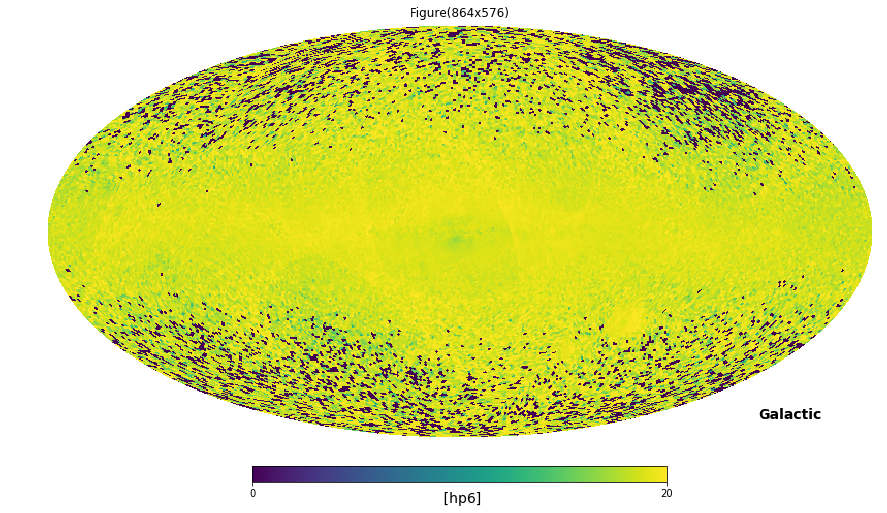

In [16]:
hpX.setValues(d,sourceId="source_id",keyValue="phot_g_mean_mag")
f = plt.figure()
hpX.plot(f,cmap=mp.cm.viridis,vmin=0,vmax=20,coord='G')

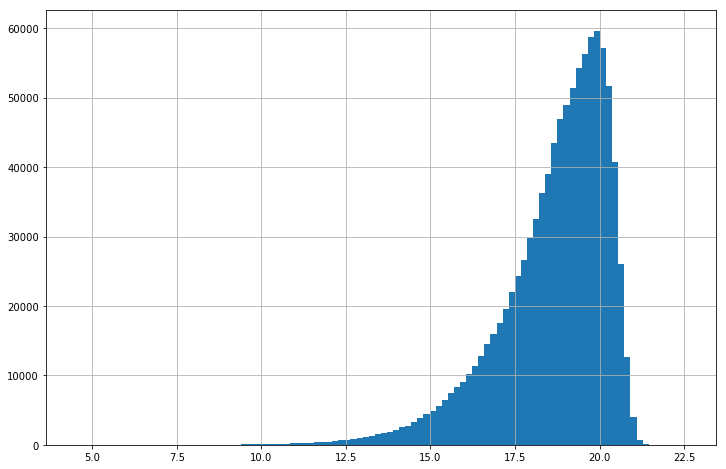

In [17]:
d.phot_g_mean_mag.hist(bins=100)

In [18]:
print(len(hpX.values),hpX.shape,len(d),len(d)/hpX.shape)

49152 49152 1000000 20.345052083333332


In [19]:
hpX = hpExpr(level)
hpX.setCount(d,sourceId="source_id")
model = pd.DataFrame()
model['density'] = hpX.values/len(d)
model['hp'] = model.index

note the normalistation

In [20]:
model.density.sum()

1.0

pixel area in steradian

In [21]:
hp.pixelfunc.nside2pixarea(hpX.NSIDE)*hpX.shape/(4*np.pi)

1.0

given a healpix index what is the probability that a source in this healpix has 4 neighbours with 5 arcseconds?

In [22]:
import astropy.units as u

From steradian definition, if $\theta \in [0,\pi] $ is the cone angle, then the spherical cap surface on a sphere of radius $r$ is $2 \pi\, r^2 (1-\cos{\theta})$, the surface of the sphere being $4 \pi r^2$, generating a random source using a uniform distribution on the sphere, the probability to have the source in the spherical cap is
$$ \frac{1-\cos{\theta}}{2}$$

Note the probability density function of the angular distribution of points uniformly distributed on the sphere
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4196685/

$$ \frac{1}{2}\sin{\theta} \,,\theta \in [0,\pi]$$

$$ E(\theta\leq \Theta) = \frac{1}{2} \int_0^{\Theta} \sin{\theta} \, d\theta$$


Given the healpix source distribution, generating a random source on the sphere with a non uniform healpix distribution, the probability to have the source in the spherical cap of size $\theta$ included in the pixel $i$ is
$$ p_i(\theta)  = d \frac{2 \pi (1-\cos{\theta})}{A} = n\, \, d_i \frac{1-\cos{\theta}}{2} $$
with $n$ the number of pixel, $A = 4 \pi /n $ the area of the pixel and $d_i$ the density distribution of the sources in pixel i.


Generating N sources, the expected number of condaminant for a QSO in healpix pixel $i$ is $N p_i(\theta) $ with $N$ the total number of sources.

In [23]:
N = 1e9
theta = u.arcsecond.to(u.rad)*5
p = (1 - np.cos(theta))/2

mean number of sources per pixel

In [24]:
N/hpX.shape

20345.052083333332

max number of sources per pixel

In [25]:
np.max(model.density)*N

396000.0

expected number of sources in a spherical cap of 5 arcsec for a uniform distribution

In [26]:
N*p

0.14690271221695639

In [27]:
model['prob'] = hpX.shape*p*model.density

expected number of sources in a spherical cap of 5 arcsec taking in account the expected number of sources in each pixel

In [39]:
model['n_outliers'] = N*model.prob

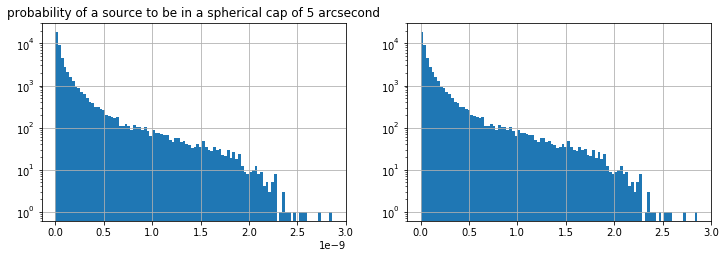

In [40]:
plt.subplot(221)
model.prob.hist(bins=100)
plt.yscale('log')
plt.title('probability of a source to be in a spherical cap of 5 arcsecond')

plt.subplot(222)
model.n_outliers.hist(bins=100)
plt.yscale('log')

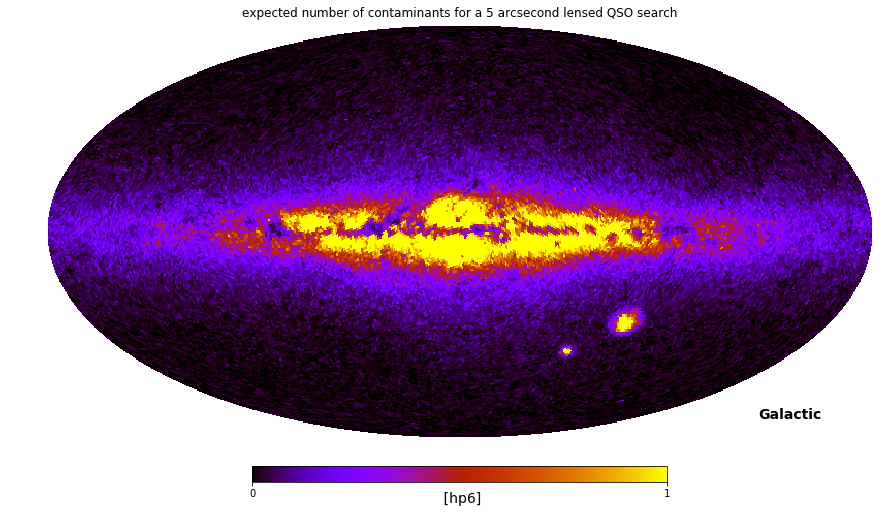

In [30]:
f = plt.figure()
hpX.setHpValues(model,keyValue='n_outliers')
hpX.plot(f,cmap=mp.cm.gnuplot,vmin=0,vmax=1,coord='G')
plt.title("expected number of contaminants for a 5 arcsecond lensed QSO search")

In [31]:
def hp_model(d,i,N = 1e9,theta = 5):
    p = (1 - np.cos(theta*u.arcsecond.to(u.rad)))/2
    hpX = hpExpr(i)
    hpX.setCount(d,sourceId="source_id")
    model = pd.DataFrame()
    model['density'] = hpX.values/len(d)
    model['hp'] = model.index
    model['prob'] = hpX.shape*p*model.density
    model['n_outliers'] = N*model.prob
    return model

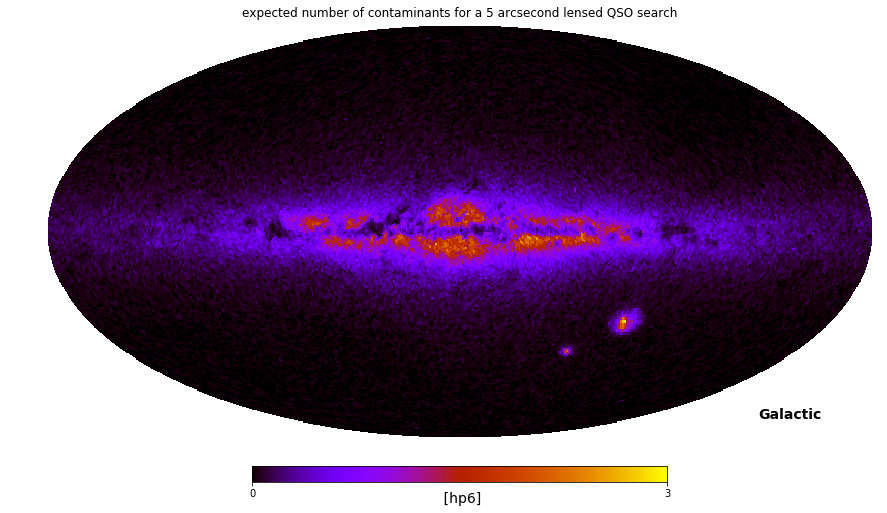

In [32]:
m = hp_model(d,level)
f = plt.figure()
hpX = hpExpr(level)
hpX.setHpValues(m,keyValue='n_outliers')
hpX.plot(f,cmap=mp.cm.gnuplot,vmin=0,vmax=3,coord='G')
plt.title("expected number of contaminants for a 5 arcsecond lensed QSO search")

In [33]:
m.to_csv("data/contaminantModel.csv")

from this model one can generate some random sample by using a poisson distribution given the expected number of contaminants